## 分布のインピュテーションの終了

前のノートブックでは、欠損データを任意の値で置き換えました。しかし、任意の値を決めるのは手間がかかるので、通常は手作業で行います。変数の分布の最後に任意の値を自動的に選択することで、この作業を自動化することができます。

#### 末端の値はどのようにして選択するのでしょうか？

- 変数が正規分布であれば、平均値に標準偏差の3倍を加えた値を使用できます。
- 変数が歪んでいる場合は、IQR 近傍規則を使用できます。

これらのテクニックは、セクション3の「外れ値」の講義で学びました。

- また、最小値や最大値を選択して、それに2や3のように一定の倍数をかけることもできます。


### どの変数に任意の値を代入できますか？

この方法は、数値変数に適しています。

### 前提条件

- MNAR - 値が無作為に欠損していない

値が無作為に欠落していない場合、その値を平均値や中央値に置き換えて、その観測値を大多数の観測値のようにしたくはありません。その代わりに、その観測値が異なるものであることを示したいので、母集団の中で観測値がほとんど存在しない分布の末尾にある値を割り当てます。


### メリット

- 実装が簡単
- 完全なデータセットを迅速に得ることができる
- 生産ラインに組み込むことができる（モデル展開時に）
- 欠測」がある場合、その重要性を把握できる

### デメリット

- 元の変数分布の歪み
- 元の分散の歪み
- データセットの残りの変数との共分散の歪み
- 分布の中の真の外れ値を隠してしまう可能性がある。


### 最後の注意

この手法をデータコンペで見たことはありませんが、金融会社ではこの手法が使われています。顧客の金融履歴を取得する際に、欠損がランダムであると仮定しないために、欠損データを分布の最後の方の値で置き換えるのです。

金融におけるフィーチャーエンジニアリングの例は、私の[talk at PyData London in 2017](https://www.youtube.com/watch?v=KHGGlozsRtA)を参照してください。

## このデモでは。

Ames House PriceとTitanic Datasetsでpandasを使って任意の値のインピュテーションを行う方法を学びます。

- データセットをダウンロードするには、本講座の**セクション1**にある**Datasets**という講義を参照してください。


===>>


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# データセットを分割する
from sklearn.model_selection import train_test_split

In [4]:
# デモのためにいくつかの変数を使ってTitanicデータセットを読み込む

data = pd.read_csv('/content/drive/MyDrive/特徴量工学/Section-04-Missing-Data-Imputation/titanic.csv', usecols=['age', 'fare', 'survived'])
data.head()

,survived,age,fare
0,1,29,211.3375
1,1,0.9167,151.55
2,0,2,151.55
3,0,30,151.55
4,0,25,151.55


In [5]:
# NAの割合を見てみよう

data.isnull().mean()

survived    0.0
age         0.0
fare        0.0
dtype: float64

### インピュテーションの重要性

インピュテーションはトレーニングセットで行われ、テストセットに伝搬される必要があります。このインピュテーションの手法では、NAを置き換える値を選択する際に、トレーニングセットの変数の分布を見るだけでよいことになります。そして，選択された値を用いて，訓練セットとテストセットの両方でNAを置き換えるのです．


In [6]:
# トレーニングセットとテストセットに分けよう

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']], # 予測変数
    data['survived'], #ターゲット
    test_size=0.3, # テストセットに含まれるオブの割合
    random_state=0) # 再現性を確保するためのシード

X_train.shape, X_test.shape


((916, 2), (393, 2))

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


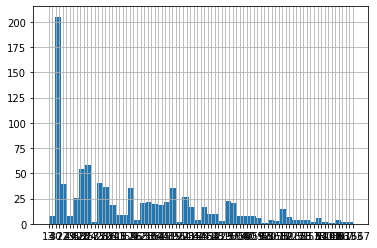

In [7]:
# Agesの分布を見てみよう
X_train.age.hist(bins=50)

In [8]:
# 欠損値を極値で埋める関数を作ってみましょう。
# the variable は、データフレーム、変数、および na を置換する値を受け取ります。

# そして、埋められたnaを持つ変数を返す

def impute_na(df, variable, value):

    return df[variable].fillna(value)

In [9]:

# 分布の遠端。

# Ageはほぼガウス型なので、平均値と標準値を使って
# 平均値と標準値を使って置換値を計算します。

X_train.age.mean() + 3 * X_train.age.std()

TypeError: ignored

In [10]:
# NAを上記で計算した値で置き換える

X_train['Age_imputed'] = impute_na(X_train, 'age',
                                   X_train.age.mean() + 3 * X_train.age.std())

X_train.head(15)

TypeError: ignored

Ageの欠損データ(NaN)の行を見て、新しい変数では73.436に置き換えられていることを確認してください。


In [ ]:
# 尾行終了時のインピュテーション後の分散の変化がわかります。
# これは，欠損データの割合が非常に高いことから予想されます．
# Ageの20%という高い数値


print('Original variable variance: ', X_train['age'].var())
print('Variance after 99 imputation: ', X_train['Age_imputed'].var())

In [ ]:
# 分布が変化していることがわかる 
# より多くの値がテールに向かって蓄積されていることがわかる

fig = plt.figure()
ax = fig.add_subplot(111)

# 元の変数の分布
X_train['age'].plot(kind='kde', ax=ax)

# インプットされた変数
X_train['Age_imputed'].plot(kind='kde', ax=ax, color='red')

# 凡例の追加
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')


前述のように，任意の値のインピュテーションと同様に，末尾のインピュテーションは，変数Ageの元の分布を歪める．変換された変数は、選択された末尾の値の周りにより多くの値を示します。

**これは重要なことなのでしょうか？

これは、構築したい機械学習モデルに依存します。線形モデルは、変数が正規分布していることを前提としています。欠損データの割合が高い場合、末尾のインピュテーションは元の正規分布を歪める可能性があります。そのため，最終的に入力された変数は正規分布ではなくなり，線形モデルのパフォーマンスに影響を与える可能性があります．

一方で，この手法は木をベースにしたアルゴリズムとの相性が非常に良いです．


In [11]:

# 我々はまた、末尾の組換えがデータの他の変数との関係に # 影響を与えるかもしれないと言った 
# データセットの他の変数との関係に影響を与えるかもしれないと言いましたが、それを見てみましょう


X_train[['fare', 'age', 'Age_imputed']].cov()

KeyError: ignored

確かに、年齢とFareの共分散は、任意の値のインピュテーションの後に変化していることがわかります。

In [ ]:
# 最後に，エンドテール・インピュテーションが
# 外れ値の認識に影響すると述べた

# 箱ひげ図を使って調べてみよう
X_train[['age', 'Age_imputed']].boxplot()

外れ値を隠します!

# # House Prices Dataset

家屋価格のデータセットで練習を繰り返してみましょう。 このデータセットでは、欠損データが多いまたは少ない変数があります。 したがって、エンドテール・インピュテーションの効果を両方のシナリオで比較することができます。




In [ ]:
# 以下の変数のみを使用することにします。
# そのうち3つはNAを含みます


cols_to_use = [
    'OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF',
    'BsmtUnfSF', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice'
]

In [ ]:
# House Prices データセットをロードします。

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
print(data.shape)
data.head()

In [ ]:
# 次のリスト comprehensionでは、データセットのすべての列をループして 
# データセットのすべての列をループして 欠損データを含む列を選択する

[var for var in data.columns if data[var].isnull().sum()>0]

In [ ]:

# それらの変数における欠損データの割合を求める
# セクション3の変数の特徴で学んだのと同じコードです。

data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].isnull().mean()

In [ ]:

# トレーニングセットとテストセットに分けよう

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

In [ ]:
# 変数の分布をプロットしてみよう
# このコードはセクション3の変数の特性で学びました

X_train[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].hist(bins=50, figsize=(10,10))
plt.show()

In [ ]:
# 変数は正規分布ではない

# IQR近似ルールを使ってNAを入力しましょう。これはセクション3の外れ値の講義で学びました。
# セクション3の外れ値の講義で学んだ

# IQRの計算
IQR = X_train['LotFrontage'].quantile(0.75) - X_train['LotFrontage'].quantile(
    0.25)

# 上限値の計算
extreme_value = X_train['LotFrontage'].quantile(0.75) + 3 * IQR
extreme_value


In [ ]:
# NAに極値をインピュートしてみましょう

X_train.loc[:,'LotFrontage_imputed'] = impute_na(X_train, 'LotFrontage', extreme_value)
X_test.loc[:,'LotFrontage_imputed'] = impute_na(X_test, 'LotFrontage', extreme_value)

In [ ]:
# MasVnrAreaについても同じことをしてみましょう

# IQRの計算
IQR = X_train['MasVnrArea'].quantile(0.75) - X_train['MasVnrArea'].quantile(
    0.25)

# 上限値の計算
extreme_value = X_train['MasVnrArea'].quantile(0.75) + 3 * IQR

extreme_value


In [ ]:
# NAを極値でインプットしてみよう

X_train.loc[:,'MasVnrArea_imputed'] = impute_na(X_train, 'MasVnrArea', extreme_value)
X_test.loc[:,'MasVnrArea_imputed'] = impute_na(X_test, 'MasVnrArea', extreme_value)

In [ ]:
# 分布に対する末尾のインピュテーションの効果を評価してみよう

# LotFrontAgeの分布が変化していることがわかる
# 極値に向かってより多くの値が蓄積されるようになった

fig = plt.figure()
ax = fig.add_subplot(111)

# 元の変数の分布
X_train['LotFrontage'].plot(kind='kde', ax=ax)

# インプットされた変数
X_train['LotFrontage_imputed'].plot(kind='kde', ax=ax, color='red')

# 凡例の追加
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')



In [ ]:

# 任意のインピュテーションが分布に与える影響を評価してみよう

# MasVnrArea は外れ値が少なかったので，分布の変化は
#それほど劇的ではない．2999という任意の値を使用したときよりも少ない
# 前のノートブックで行ったように

fig = plt.figure()
ax = fig.add_subplot(111)

# 元の変数の分布
X_train['MasVnrArea'].plot(kind='kde', ax=ax)

# インプットされた変数
X_train['MasVnrArea_imputed'].plot(kind='kde', ax=ax, color='red')

# 凡例の追加
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')



上のプロットから，LotFrontAgeの分布はかなり劇的に変化していることがわかりますが，MasVnrAreaの分布はそれほど変化していません。これは、2つ目の変数の欠損値の割合が非常に小さいからです。


In [ ]:
# インピュテーションの結果，外れ値も少なくなったことがわかる．

X_train[['LotFrontage', 'LotFrontage_imputed']].boxplot()

In [ ]:
# しかし，MasVnrAreaでは，外れ値はそれほど影響を受けない．

X_train[['MasVnrArea', 'MasVnrArea_imputed']].boxplot()

In [ ]:
# 同様に，インピュテーション技術の影響を調べることができる．
# The variance

# LotFrontAgeでは，帰納法による分散の変化が見られます．
# これは，欠損データの割合が非常に高いことから予想される．
# 高い #20%


print('Original Variance: ', X_train['LotFrontage'].var())
print('Variance after imputation: ', X_train['LotFrontage_imputed'].var())

In [ ]:
# 同じく MasnVnrArea については，それほど大きくはない．
# 特に、この効果は、我々が観察した効果よりも小さいことに注意してください。
# 前のノートブックで2999で入力したときの効果よりも小さいことに注意してください。

print('Original Variance: ', X_train['MasVnrArea'].var())
print('Variance after imputation: ', X_train['MasVnrArea_imputed'].var())

In [ ]:

# 最後に，共分散を調べてみましょう．
# 以下の表の値をじっくりと比較してみてください。

X_train.cov()

**今回のデモはこれで終わりです。ノートブックを楽しんでいただけましたら幸いです。
